In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
Z_DIM = 100

NUM_EPOCHS = 10

NUM_VIDEO_FRAMES = 200
VIDEO_FPS = 10
VIDEO_FILENAME = "generated_digit_video.avi"
VIDEO_CODEC = 'DIVX' 

Using device: cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IMAGE_CHANNELS)], [0.5 for _ in range(IMAGE_CHANNELS)]),
])

In [7]:
transform

Compose(
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(IMAGE_CHANNELS)], [0.5 for _ in range(IMAGE_CHANNELS)]),
])

try:
    dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"MNIST dataset loaded successfully. Found {len(dataset)} images.")

except Exception as e:
    print(f"Error loading MNIST dataset: {e}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

MNIST dataset loaded successfully. Found 60000 images.


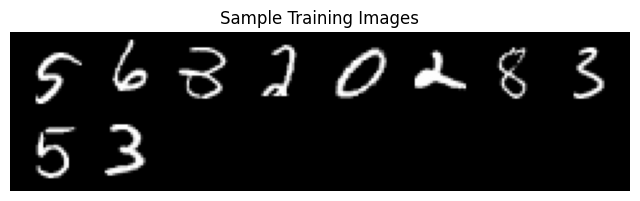

In [12]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0][:10].to(DEVICE), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            # Input: z_dim noise vector
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1), # Leaky ReLU is common in GANs
            nn.Linear(256, img_dim),
            # Output: flattened image vector (e.g., 1*28*28 = 784)
            nn.Tanh(), # Output pixels in [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [14]:
G_test = Generator(Z_DIM, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNELS)
noise_test = torch.randn((BATCH_SIZE, Z_DIM))
output_test = G_test(noise_test)
print("Generator output shape:", output_test.shape)

Generator output shape: torch.Size([128, 784])


In [19]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [20]:
D_test = Discriminator(IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNELS)
img_test = torch.randn((BATCH_SIZE, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNELS))
output_test = D_test(img_test)
print("Discriminator output shape:", output_test.shape) # Should be (BATCH_SIZE, 1)

Discriminator output shape: torch.Size([128, 1])


In [21]:
IMG_DIM = IMAGE_SIZE * IMAGE_SIZE * IMAGE_CHANNELS # 784 for MNIST


gen = Generator(Z_DIM, IMG_DIM).to(DEVICE)
disc = Discriminator(IMG_DIM).to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) # betas commonly used in GAN papers
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))


criterion = nn.BCELoss()
fixed_noise = torch.randn(64, Z_DIM).to(DEVICE)

Generator and Discriminator models initialized.


In [22]:
print(f"\n--- Starting GAN Training for {NUM_EPOCHS} epochs ---")
start_time = time.time()
g_losses = []
d_losses = []

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = len(dataloader)

    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, IMG_DIM).to(DEVICE) # Flatten real images
        batch_size = real_imgs.shape[0]
        noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
        fake_imgs = gen(noise)
        disc_real_pred = disc(real_imgs)
        loss_disc_real = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_fake_pred = disc(fake_imgs.detach())
        loss_disc_fake = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        opt_disc.zero_grad()
        loss_disc.backward() # Compute gradients
        opt_disc.step() # Update weights

        disc_fake_pred_for_gen = disc(fake_imgs)
        loss_gen = criterion(disc_fake_pred_for_gen, torch.ones_like(disc_fake_pred_for_gen))

        opt_gen.zero_grad()
        loss_gen.backward() # Compute gradients
        opt_gen.step()      # Update weights

        # --- Logging ---
        epoch_d_loss += loss_disc.item()
        epoch_g_loss += loss_gen.item()

        if (batch_idx + 1) % 100 == 0:
             print(f"  Epoch [{epoch+1}/{NUM_EPOCHS}] Batch [{batch_idx+1}/{num_batches}] "
                   f"Loss D: {loss_disc.item():.4f}, Loss G: {loss_gen.item():.4f}")

    # --- End of Epoch ---
    avg_epoch_g_loss = epoch_g_loss / num_batches
    avg_epoch_d_loss = epoch_d_loss / num_batches
    epoch_end_time = time.time()
    print(f"--- Epoch {epoch+1} finished ---")
    print(f"  Avg Loss D: {avg_epoch_d_loss:.4f}, Avg Loss G: {avg_epoch_g_loss:.4f}")
    print(f"  Time taken: {epoch_end_time - epoch_start_time:.2f} seconds")

    g_losses.append(avg_epoch_g_loss)
    d_losses.append(avg_epoch_d_loss)


training_end_time = time.time()
print(f"\n--- Training Complete ---")
print(f"Total Training Time: {training_end_time - start_time:.2f} seconds")

# --- Save the trained generator model ---
MODEL_SAVE_PATH = 'mnist_generator.pth'
torch.save(gen.state_dict(), MODEL_SAVE_PATH)
print(f"Generator model state saved to {MODEL_SAVE_PATH}")


--- Starting GAN Training for 10 epochs ---
  Epoch [1/10] Batch [100/469] Loss D: 0.6124, Loss G: 0.5451
  Epoch [1/10] Batch [200/469] Loss D: 0.6433, Loss G: 0.5991
  Epoch [1/10] Batch [300/469] Loss D: 0.6149, Loss G: 0.6818
  Epoch [1/10] Batch [400/469] Loss D: 0.5902, Loss G: 0.7618
--- Epoch 1 finished ---
  Avg Loss D: 0.5947, Avg Loss G: 0.6522
  Time taken: 11.06 seconds
  Epoch [2/10] Batch [100/469] Loss D: 0.5500, Loss G: 0.8140
  Epoch [2/10] Batch [200/469] Loss D: 0.5837, Loss G: 0.8038
  Epoch [2/10] Batch [300/469] Loss D: 0.5902, Loss G: 0.7945
  Epoch [2/10] Batch [400/469] Loss D: 0.5913, Loss G: 0.8021
--- Epoch 2 finished ---
  Avg Loss D: 0.5747, Avg Loss G: 0.8048
  Time taken: 10.99 seconds
  Epoch [3/10] Batch [100/469] Loss D: 0.5661, Loss G: 0.8217
  Epoch [3/10] Batch [200/469] Loss D: 0.5675, Loss G: 0.7829
  Epoch [3/10] Batch [300/469] Loss D: 0.5738, Loss G: 0.8547
  Epoch [3/10] Batch [400/469] Loss D: 0.5628, Loss G: 0.8191
--- Epoch 3 finished --

In [28]:
if 'gen' not in locals():
   gen = Generator(Z_DIM, IMG_DIM).to(DEVICE)
   try:
        gen.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        print(f"Loaded trained generator state from {MODEL_SAVE_PATH}")
   except FileNotFoundError:
        print(f"Error: Model file '{MODEL_SAVE_PATH}' not found. Train the model first.")
        exit()
   except Exception as e:
        print(f"Error loading model state: {e}")
        exit()


gen.eval()

generated_frames = []

with torch.no_grad(): 
    for i in range(NUM_VIDEO_FRAMES):
       
        noise = torch.randn(1, Z_DIM).to(DEVICE) # Generate one frame at a time

        fake_img_vector = gen(noise)

        fake_img = fake_img_vector.view(IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)

        img_normalized = (fake_img * 0.5) + 0.51]
        img_uint8 = (img_normalized * 255).clamp(0, 255).byte() 

        frame_np = img_uint8.cpu().numpy().transpose(1, 2, 0) 
        if IMAGE_CHANNELS == 1:
            frame_np = frame_np.squeeze(axis=2) 

        generated_frames.append(frame_np)

        if (i + 1) % 20 == 0:
            print(f"  Generated frame {i+1}/{NUM_VIDEO_FRAMES}")

print(f"Finished generating {len(generated_frames)} frames.")


--- Generating 200 frames for video ---
  Generated frame 20/200
  Generated frame 40/200
  Generated frame 60/200
  Generated frame 80/200
  Generated frame 100/200
  Generated frame 120/200
  Generated frame 140/200
  Generated frame 160/200
  Generated frame 180/200
  Generated frame 200/200
Finished generating 200 frames.


In [44]:

print(f"\n--- Attempting to compile video using different codecs ---")
print(f"Frames generated: {len(generated_frames)}")
if len(generated_frames) > 0:
    print(f"Frame shape: {generated_frames[0].shape}, dtype: {generated_frames[0].dtype}")

height, width = generated_frames[0].shape[:2]

is_color = False
codecs_to_try = ['MJPG', 'DIVX']

success_count = 0
for codec in codecs_to_try:
    if isinstance(codec, str):
        codec_name = codec
        
        fourcc = cv2.VideoWriter_fourcc(*codec_name.upper())
        
    output_filename = f"generate_{codec_name}.avi"
    output_path = os.path.join("/kaggle/working/", output_filename) # Explicit path

    print(f"\nAttempting Codec: {codec_name} | FourCC: {fourcc:#010x} | Output: {output_path}")

    out = None 
    try:
        out = cv2.VideoWriter(output_path, fourcc, VIDEO_FPS, (width, height), isColor=is_color)

        if not out.isOpened():

            raise IOError(f"cv2.VideoWriter failed to open for codec '{codec_name}'. It might not be supported/installed in this environment.")

        print(f"  VideoWriter opened successfully for '{codec_name}'. Writing {len(generated_frames)} frames...")

        for i, frame in enumerate(generated_frames):

            if i < 5:
                if not isinstance(frame, np.ndarray) or frame.shape != (height, width) or frame.dtype != np.uint8:
                    print(f"  WARNING: Frame {i} has unexpected format! Shape: {frame.shape}, Dtype: {frame.dtype}. Skipping write.")
                    continue 
            try:
                out.write(frame)
            except Exception as write_err:
                print(f"  ERROR: Failed to write frame {i} using codec '{codec_name}': {write_err}")

        print(f"  Finished writing frames for codec '{codec_name}'. Releasing writer...")

        out.release()
        out = None

        if os.path.exists(output_path):
             file_size_kb = os.path.getsize(output_path) / 1024
             print(f"  Video saved: {output_path} | Size: {file_size_kb:.2f} KB")
             if file_size_kb < 10 and len(generated_frames) > 10: # Arbitrary check for suspicious size
                  print("  WARNING: File size seems unexpectedly small!")
             success_count += 1
        else:
             print(f"  ERROR: File not found after supposedly saving: {output_path}")

    except (IOError, cv2.error) as e:
         print(f"  ERROR for Codec '{codec_name}': {e}")
         if out is not None and out.isOpened():
              out.release()
    finally:
         if out is not None and out.isOpened():
              print("  Releasing writer in finally block...")
              out.release()


print(f"\n--- Finished attempting video compilation ---")

if success_count == 0 and OPENCV_AVAILABLE and generated_frames:
 print("No video files were successfully created.")


--- Attempting to compile video using different codecs ---
Frames generated: 200
Frame shape: (28, 28), dtype: uint8

Attempting Codec: MJPG | FourCC: 0x47504a4d | Output: /kaggle/working/generate_MJPG.avi
  VideoWriter opened successfully for 'MJPG'. Writing 200 frames...
  Finished writing frames for codec 'MJPG'. Releasing writer...
  Video saved: /kaggle/working/generate_MJPG.avi | Size: 126.71 KB

Attempting Codec: DIVX | FourCC: 0x58564944 | Output: /kaggle/working/generate_DIVX.avi
  VideoWriter opened successfully for 'DIVX'. Writing 200 frames...
  Finished writing frames for codec 'DIVX'. Releasing writer...
  Video saved: /kaggle/working/generate_DIVX.avi | Size: 48.91 KB

Attempting Codec: RAW_UNCOMPRESSED | FourCC: 0x00000000 | Output: /kaggle/working/generate_RAW_UNCOMPRESSED.avi
  VideoWriter opened successfully for 'RAW_UNCOMPRESSED'. Writing 200 frames...
  Finished writing frames for codec 'RAW_UNCOMPRESSED'. Releasing writer...
  Video saved: /kaggle/working/generat